# Treating data from the Sistema de Informação sobre Mortalidade (SIM) provied by the Ministério da Saúde for national data

In [48]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

## Loading data

In [49]:
df_raw = pd.read_csv("data/output/df_sim_raw.csv", dtype=str)

In [50]:
date_columns = ['DTOBITO','DTATESTADO', 'DTNASC', 'DTCADASTRO', 'DTRECEBIM', 'DTRECORIGA','DTCADINF', 'DTCADINV', 'DTCONCASO', 'DTINVESTIG']
df_raw[date_columns] = df_raw[date_columns].apply(pd.to_datetime, format='%d%m%Y')

In [51]:
df_municipal_base = pd.read_csv('../brazilian_municipalities/data/output/df_municpal.csv', dtype=str)[['MUNICIPIO','CODIGO_MUNICIPIO_6','SIGLA_ESTADO','ESTADO','REGIAO','POPULACAO_2022']]
df_municipal_base.POPULACAO_2022 = df_municipal_base.POPULACAO_2022.astype(int)
brazil_population_2022 = df_municipal_base.POPULACAO_2022.sum()

In [52]:
brazil_population_2022

203062512

## Utils

In [53]:
DATE_FIRST_DEATH = datetime.fromisoformat('2020-03-12')
DATE_STUDY_END = datetime.fromisoformat('2022-12-31')

## Describing data

In [54]:
df_raw.DTOBITO.min()

Timestamp('2020-01-22 00:00:00')

In [55]:
df_raw.DTOBITO.max()

Timestamp('2022-12-31 00:00:00')

In [56]:
df_raw.DTOBITO.unique().shape[0]

1027

In [57]:
len(df_raw)

702559

## Anomalies

### Missing data

In [58]:
df_raw.isnull().any()

DTOBITO       False
DTNASC         True
SEXO          False
RACACOR        True
ESC            True
ESC2010        True
SERIESCFAL     True
OCUP           True
CODMUNRES     False
LOCOCOR       False
CODMUNOCOR    False
SEMAGESTAC     True
GESTACAO       True
OBITOGRAV      True
LINHAA         True
LINHAB         True
LINHAC         True
LINHAD         True
LINHAII        True
CAUSABAS      False
CB_PRE         True
COMUNSVOIM     True
DTATESTADO     True
DTINVESTIG     True
CAUSABAS_O     True
DTCADASTRO     True
DTRECEBIM      True
ATESTADO      False
DTRECORIGA    False
CAUSAMAT       True
STDOEPIDEM    False
DIFDATA       False
NUDIASOBCO     True
DTCADINV       True
TPOBITOCOR     True
DTCONINV       True
TPRESGINFO     True
TPNIVELINV     True
DTCADINF       True
DTCONCASO      True
ALTCAUSA       True
CONTADOR      False
dtype: bool

### Noised data

#### Date of first death

The first death occurred on March 12, 2020, in São Paulo. The patient was a woman of 57 years old.
https://www.cnnbrasil.com.br/saude/primeira-morte-por-covid-19-no-pais-ocorreu-em-12-de-marco-em-sp-diz-ministerio/
https://www.cnnbrasil.com.br/saude/1a-morte-por-covid-19-no-brasil-ocorreu-ha-3-anos-como-a-vacinacao-mudou-o-cenario-da-doenca/
https://www.cnnbrasil.com.br/saude/ministerio-diz-que-primeira-morte-por-covid-19-foi-em-janeiro/

In [59]:
df_raw[df_raw.DTOBITO < DATE_FIRST_DEATH]

,DTOBITO,DTNASC,SEXO,RACACOR,ESC,ESC2010,SERIESCFAL,OCUP,CODMUNRES,LOCOCOR,...,NUDIASOBCO,DTCADINV,TPOBITOCOR,DTCONINV,TPRESGINFO,TPNIVELINV,DTCADINF,DTCONCASO,ALTCAUSA,CONTADOR
51385,2020-03-02,1927-03-12,2,1,3,2,NaN,999992,211130,1,...,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,399021
89536,2020-01-22,1935-06-20,2,4,1,0,NaN,NaN,261500,3,...,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,401051


In [60]:
df_raw[df_raw.DTOBITO == DATE_FIRST_DEATH]

,DTOBITO,DTNASC,SEXO,RACACOR,ESC,ESC2010,SERIESCFAL,OCUP,CODMUNRES,LOCOCOR,...,NUDIASOBCO,DTCADINV,TPOBITOCOR,DTCONINV,TPRESGINFO,TPNIVELINV,DTCADINF,DTCONCASO,ALTCAUSA,CONTADOR
92842,2020-03-12,1937-05-08,1,1,3,2,NaN,141405,260790,2,...,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,748281
169511,2020-03-12,1962-06-19,2,1,4,2,8,999992,355030,1,...,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,219318


### Seasonality

In [61]:
df_national = df_raw.groupby('DTOBITO').count().reset_index()

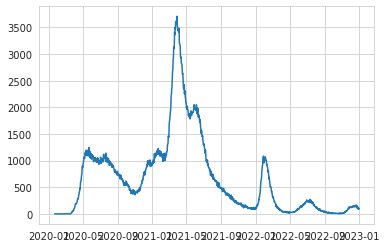

In [62]:
plt.plot(df_national.DTOBITO, df_national.CODMUNRES)
plt.show()

In [63]:
# Group data by day of the week
df_national['day_of_week'] = df_national.DTOBITO.dt.dayofweek

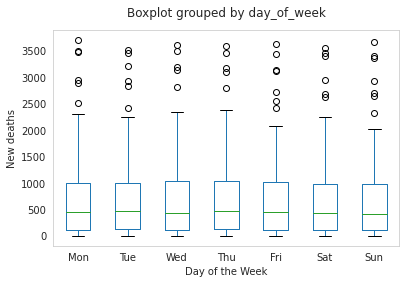

In [64]:
df_national.boxplot(column='CODMUNRES', by='day_of_week', grid=False)

# Customize plot
plt.title(None)
plt.xlabel('Day of the Week')
plt.ylabel('New deaths')
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Show the plot
plt.show()

#### Noise in death date
Despite we note noise in data, we prefer not change the data. 

In [65]:
df_raw['DIFDATA'] = df_raw.DIFDATA.astype(int)

df_raw['DIFDATA_CADASTRO_OBITO'] = (df_raw.DTCADASTRO - df_raw.DTOBITO).dt.days
df_raw['DIFDATA_CADASTRO_ATESTADO'] = (df_raw.DTCADASTRO - df_raw.DTATESTADO).dt.days
df_raw['DIFDATA_ATESTADO_OBITO'] = (df_raw.DTATESTADO - df_raw.DTOBITO).dt.days

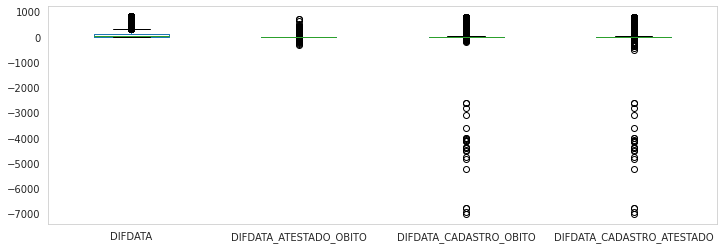

In [66]:
df_raw.boxplot(column=['DIFDATA', 'DIFDATA_ATESTADO_OBITO', 'DIFDATA_CADASTRO_OBITO', 'DIFDATA_CADASTRO_ATESTADO'], grid=False, figsize=(12,4))

# Show the plot
plt.show()

In [67]:
df_raw.DIFDATA_ATESTADO_OBITO.describe()

count    701741.000000
mean          0.269850
std           5.658117
min        -304.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         730.000000
Name: DIFDATA_ATESTADO_OBITO, dtype: float64

In [68]:
len(df_raw[df_raw.DIFDATA_ATESTADO_OBITO!=0])

40317

In [69]:
len(df_raw[df_raw.DIFDATA_ATESTADO_OBITO<0])

76

In [70]:
len(df_raw[df_raw.DIFDATA_ATESTADO_OBITO>28])

1234

## Treating anomalies

### Treating dates

In [71]:
df_raw = df_raw[(df_raw.DTOBITO >= DATE_FIRST_DEATH) & (df_raw.DTOBITO <= DATE_STUDY_END)]
df_raw.shape

(702557, 45)

## Prepareing national time series

In [72]:
df_covid_deaths_national_timeseries_sim = df_raw.groupby(['DTOBITO']).count().reset_index()[['DTOBITO','CAUSABAS']].copy()

In [73]:
df_covid_deaths_national_timeseries_sim = df_covid_deaths_national_timeseries_sim.rename(columns={'DTOBITO': 'DATA', 'CAUSABAS': 'OBITOS_NOVOS'})

In [74]:
df_covid_deaths_national_timeseries_sim = df_covid_deaths_national_timeseries_sim.sort_values('DATA')
df_covid_deaths_national_timeseries_sim['OBITOS'] = df_covid_deaths_national_timeseries_sim['OBITOS_NOVOS'].cumsum()

In [75]:
df_covid_deaths_national_timeseries_sim['day_of_week'] = df_covid_deaths_national_timeseries_sim.DATA.dt.dayofweek
proportion_day_of_week = df_covid_deaths_national_timeseries_sim.groupby(['day_of_week']).sum()[['OBITOS_NOVOS']] / df_covid_deaths_national_timeseries_sim.sum()[['OBITOS_NOVOS']]

In [76]:
proportion_day_of_week = proportion_day_of_week.reset_index()

In [77]:
proportion_day_of_week

,day_of_week,OBITOS_NOVOS
0,0,0.143937
1,1,0.142633
2,2,0.143285
3,3,0.143245
4,4,0.143177
5,5,0.142292
6,6,0.141431


Although we can not check seasonality in this data, we choice apply the moving average to smooth the data inner a week.

In [78]:
df_covid_deaths_national_timeseries_sim['OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS'] = df_covid_deaths_national_timeseries_sim['OBITOS_NOVOS'].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)

In [79]:
df_covid_deaths_national_timeseries_sim['POPULACAO_2022'] = brazil_population_2022

In [80]:
df_covid_deaths_national_timeseries_sim['TAXA_OBITOS_NOVOS'] = df_covid_deaths_national_timeseries_sim.OBITOS_NOVOS / df_covid_deaths_national_timeseries_sim.POPULACAO_2022 * 100000
df_covid_deaths_national_timeseries_sim['TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS'] = df_covid_deaths_national_timeseries_sim.OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS / df_covid_deaths_national_timeseries_sim.POPULACAO_2022 * 100000
df_covid_deaths_national_timeseries_sim['TAXA_OBITOS'] = df_covid_deaths_national_timeseries_sim.OBITOS / df_covid_deaths_national_timeseries_sim.POPULACAO_2022 * 100000

In [81]:
df_covid_deaths_national_timeseries_sim.OBITOS_NOVOS.sum()

702557

## Saving data

In [82]:
df_raw.to_csv('data/output/df_sim_national_raw_treated.csv', index=False)

In [87]:
df_raw.shape

(702557, 45)

In [88]:
df_raw.head()

,DTOBITO,DTNASC,SEXO,RACACOR,ESC,ESC2010,SERIESCFAL,OCUP,CODMUNRES,LOCOCOR,...,DTCONINV,TPRESGINFO,TPNIVELINV,DTCADINF,DTCONCASO,ALTCAUSA,CONTADOR,DIFDATA_CADASTRO_OBITO,DIFDATA_CADASTRO_ATESTADO,DIFDATA_ATESTADO_OBITO
0,2020-05-21,1942-08-10,2,4,1,0,NaN,999993,120010,1,...,NaN,NaN,NaN,NaT,NaT,NaN,606,8.0,8.0,0.0
1,2020-05-27,1943-02-19,2,4,1,0,NaN,999993,120010,1,...,NaN,NaN,NaN,NaT,NaT,NaN,612,2.0,2.0,0.0
2,2020-05-27,1975-01-14,1,1,9,9,NaN,999993,120025,1,...,NaN,NaN,NaN,NaT,NaT,NaN,613,2.0,2.0,0.0
3,2020-05-05,1972-06-10,2,1,3,2,NaN,NaN,120040,1,...,26112020,NaN,M,NaT,NaT,NaN,2664,34.0,34.0,0.0
4,2020-05-25,1939-10-04,2,4,1,0,NaN,999993,120040,1,...,NaN,NaN,NaN,NaT,NaT,NaN,6245,18.0,18.0,0.0


In [83]:
df_covid_deaths_national_timeseries_sim.to_csv('data/output/df_sim_national.csv', index=False)

In [86]:
df_covid_deaths_national_timeseries_sim.shape

(1025, 9)

In [85]:
df_covid_deaths_national_timeseries_sim.head()

,DATA,OBITOS_NOVOS,OBITOS,day_of_week,OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS,POPULACAO_2022,TAXA_OBITOS_NOVOS,TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS,TAXA_OBITOS
0,2020-03-12,2,2,3,2.000000,203062512,0.000985,0.000985,0.000985
1,2020-03-13,2,4,4,2.000000,203062512,0.000985,0.000985,0.001970
2,2020-03-14,3,7,5,2.333333,203062512,0.001477,0.001149,0.003447
3,2020-03-15,3,10,6,2.500000,203062512,0.001477,0.001231,0.004925
4,2020-03-16,6,16,0,3.200000,203062512,0.002955,0.001576,0.007879


In [89]:
df_covid_deaths_national_timeseries_sim.OBITOS_NOVOS.sum()

702557